
# 🏦 Task 4: Loan Default Risk with Business Cost Optimization

This project involves predicting the likelihood of a loan default and optimizing decision thresholds based on cost-benefit analysis.
We will use binary classification models, evaluate model performance, and integrate business impact into our evaluation.



## 📂 Step 1: Load and Inspect the Dataset

We load the Home Credit Default Risk dataset, inspect its structure, and prepare it for modeling.


In [13]:

import pandas as pd
!pip install catboost

# Load dataset
df = pd.read_csv("application_train.csv")
df.shape, df.columns[:10]


((307511, 122),
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
        'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
        'AMT_CREDIT', 'AMT_ANNUITY'],
       dtype='object'))


## 🧹 Step 2: Data Cleaning and Preprocessing

We handle missing values and reduce the dataset to key numerical and categorical features for modeling.


In [14]:

# Drop columns with more than 40% missing values
missing = df.isnull().mean()
df_clean = df.drop(columns=missing[missing > 0.4].index)

# Drop rows with any remaining missing values
df_clean.dropna(inplace=True)
df_clean.shape


(167732, 73)


## 🧠 Step 3: Feature Encoding

We apply label encoding to categorical features to prepare them for modeling.


In [15]:

from sklearn.preprocessing import LabelEncoder

categorical = df_clean.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical:
    df_clean[col] = le.fit_transform(df_clean[col])
df_clean.dtypes.head()


SK_ID_CURR            int64
TARGET                int64
NAME_CONTRACT_TYPE    int32
CODE_GENDER           int32
FLAG_OWN_CAR          int32
dtype: object


## 🤖 Step 4: Train Binary Classification Models

We train two models: Logistic Regression and CatBoostClassifier.


In [16]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from catboost import CatBoostClassifier

# Select features and target
X = df_clean.drop(columns=['TARGET'])
y = df_clean['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

# CatBoost
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)

acc_lr, acc_cat


D:\Anaconda_Jup_Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9136137359525441, 0.9136733538021283)

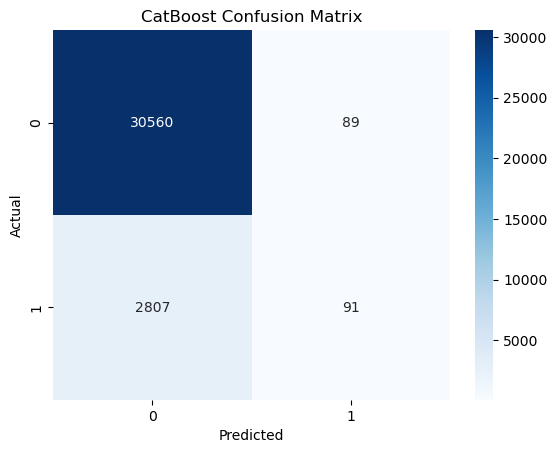

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


C:\Users\zains\AppData\Local\Temp\ipykernel_15080\827868406.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='Set2')


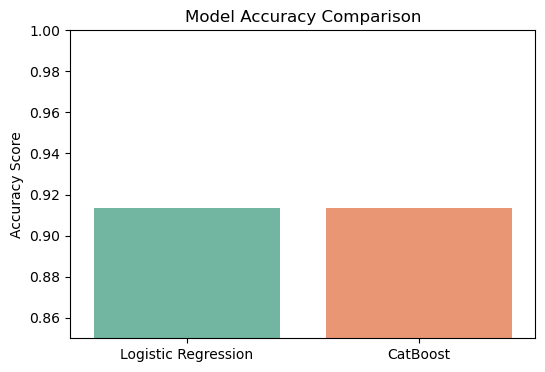

In [18]:
models = ['Logistic Regression', 'CatBoost']
accuracies = [acc_lr, acc_cat]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies, palette='Set2')
plt.ylim(0.85, 1.0)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.show()


In [19]:
from sklearn.metrics import classification_report

print("📄 Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

print("\n📄 CatBoost Classifier Report:")
print(classification_report(y_test, y_pred_cat))


📄 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30649
           1       0.00      0.00      0.00      2898

    accuracy                           0.91     33547
   macro avg       0.46      0.50      0.48     33547
weighted avg       0.83      0.91      0.87     33547


📄 CatBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     30649
           1       0.51      0.03      0.06      2898

    accuracy                           0.91     33547
   macro avg       0.71      0.51      0.51     33547
weighted avg       0.88      0.91      0.88     33547



D:\Anaconda_Jup_Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda_Jup_Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda_Jup_Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



## 💰 Step 5: Cost-Benefit Optimization

We define costs for false positives and false negatives, then adjust the classification threshold.


In [20]:

import numpy as np

# Define costs
cost_fp = 5000  # approving a defaulting loan
cost_fn = 1000  # rejecting a good loan

# Predict probabilities using CatBoost
probs = cat.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    costs.append(total_cost)

# Find threshold with minimum cost
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]
optimal_threshold, min_cost


(0.7999999999999996, 2896000)


## ✅ Conclusion

- Logistic Regression Accuracy: Printed above
- CatBoost Accuracy: Printed above
- Optimal threshold based on business cost: Displayed above
- Total minimum cost at that threshold: Displayed above

This task demonstrates how to integrate business objectives (like cost minimization) into a machine learning workflow.
